# EfficientNet
Implementation based on this [keras implementation](https://github.com/qubvel/efficientnet)

In [1]:
import math
import string
from matplotlib import pyplot
from keras.utils.generic_utils import get_custom_objects
from keras import layers, models, backend, utils, optimizers

from weights import get_weights
from constants import CONV_KERNEL_INITIALIZER, BASELINE_NETWORK_PARAMS, BlockParams

Using TensorFlow backend.
/home/michael/anaconda3/envs/dstk/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/michael/anaconda3/envs/dstk/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/michael/anaconda3/envs/dstk/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/michael/anaconda3

## Load Dataset

**Note:** I'm using CIFAR10 here because it is easy to include - the 32x32 images do not satisfy the resolution scaling coefficient of efficientnet.  I tried training this same model architecture locally with larger images and it performed well.

In [2]:
from data_loader import train_val_generators, train_val_iterators, load_cifar10
(train_x, train_y), (test_x, test_y) = load_cifar10()
train_gen, val_gen = train_val_generators()

In [3]:
input_shape = train_x[0].shape
num_classes = len(train_y[0])

## Preview Dataset

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


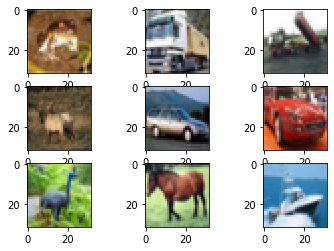

In [4]:
print('Train: X=%s, y=%s' % (train_x.shape, train_y.shape))
print('Test: X=%s, y=%s' % (test_x.shape, test_y.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(train_x[i])
# show the figure
pyplot.show()

## Helper Functions

In [5]:
def round_num_filters(base_filters, width_coeff, rounding_multiple=8):
    """To match the pretrained weights for EfficientNet, we need to round num filters to nearest multiple of 8."""
    # To round to the nearest multiple of a number: https://stackoverflow.com/questions/29557459/round-to-nearest-multiple-of-a-number
    filters = base_filters * width_coeff
    rounded_filters = int(filters + rounding_multiple / 2) // rounding_multiple * rounding_multiple
    # Minimum num filters is 8 (makes sense but I copied this part)
    rounded_filters = max(rounding_multiple, rounded_filters)
    # Do not want to round down by more than 10% (makes sense but I copied this part)
    if rounded_filters < 0.9*filters:
        rounded_filters += rounding_multiple
    return int(rounded_filters)

In [6]:
def round_num_repeats(base_repeats, depth_coefficient):
    return int(math.ceil(base_repeats * depth_coefficient))

In [7]:
def scaled_dropout(drop_connect_rate, block_num, total_blocks):
    return drop_connect_rate * float(block_num) / total_blocks

In [8]:
import collections

def flatten(x):
    """Flatten nested list."""
    return [a for i in x for a in flatten(i)] if isinstance(x, collections.Iterable) else [x]

In [9]:
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt

def plot_layer_weights(layer, input_shape=[None,224,224,3]):
    """We will use this later to look at the conv layer initialization CONV_KERNEL_INITIALIZER."""
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        input_x = tf.placeholder(tf.float32, shape=input_shape, name='input_x')  
        y = layer(input_x)
        weights = flatten(x.get_weights()[0].tolist())
        plt.hist(weights)

## MBConv Block Implementation  

The MBConv block incorporates design choices from MobileNet V1, MobileNet V2, and a few other additions

### MobileNet V1
- The initial idea behind MobileNet was that convolutional layers could be replaced by more efficient depthwise separable convolutions, even if it meant using more layers

**Normal Convolution Intuition:**  
- A typical convolution kernel needs to have as many channels as the input it's being convolved with (ex. Given Input(12x12x3), our conv. kernel needs to be Conv(5x5x3))
- This means we need to do 5x5x3=75 multiplications every time the kernel moves - the output of the convolution will be a single number, meaning Input(12x12x3) given Conv(5x5x3) will provide Out(8x8x1)

**Depthwise Separable Convolution Intuition**  
- Part 1 - Depthwise Convolution
    - Convolve the image without changing the depth - **this means convolving each of the channels separately**
    - Given Input(12x12x3), we use 3 kernels of Conv(5x5x1) that each iterate over a single channel of the image and provide Out(8x8x3)
- Part 2 - Pointwise Convolution (not used here)
    - Uses a 1x1 kernel with a depth of however many channels the input image has (in our case 3)
    - Given depthwise output Out(8x8x3), we convolve with Conv(1x1x3) to get our Out(8x8x1) output

**Why use a Depthwise Separable Convolution?**  
- If we assume 256 filters are desired for a normal convolution:
    - 256 Conv(5x5x3) kernels need to move 8x8 times - 256x3x5x5x8x8 = 1228800 multiplications
- If we assume 256 filters are desired for a depthwise separable convolution:
    - Depthwise: 3 Conv(5x5x1) kernels need to move 8x8 times - 3x5x5x8x8 = 4800 multiplications
    - Pointwise: 256 Conv(1x1x3) kernels need to move 8x8 times - 256x1x1x3x8x8 = 49152 multiplications
    - Total: 4800 + 49152 = 53952 multiplications required
- We need significantly less operations to perform a dethwise separable convolution than a normal one

### MobileNet V2 ([source](https://machinethink.net/blog/mobilenet-v2/))
- MobileNet V2 tries to keep the size of the tensors in the model relatively small thanks to bottleneck layers that make up connections between the blocks
- Onlyu using low-dimensional tensors doesn't work very well, as the following convolution layer won't be able to extract much information
- MobileNet V2 added Expansion and Projection Layers to satisfy the above objectives

#### Expansion Layer
- The expansion layer acts like a decompressor to restore the previously compressed data to its original form
- This allows the depthwise layer to perform whatever filtering is important at this stage of the network
- The expansion layer is learnable, allowing the model to figure out the best way to decompress the network

#### Projection Layer
- The projection layer acts as a compressor after the depthwise convolution, effectively zipping the tensor back up to be sent to the next block
- The projection layer is also learnable

### Squeeze-and-Excitation Networks (https://arxiv.org/pdf/1709.01507.pdf)
- In a normal convolutional neural network, each channel is weighted equally when creating output feature maps
- The idea behind these networks is to add parameters to each channel of a convolutional block so the network can adjust the weighting of each feature map
- Following the Expand -> Convolve -> Shrink logic of MobileNet V2 and keeping in mind we want to dynamically excite feature maps that have already been created, we should add the squeeze/excitation **after** the depthwise convolution

#### Squeeze
- Get a global understanding of each channel by squeezing each feature map into a single numeric value using average pooling
- This results in a vector of size n (n = number of convolutional channels)

#### Excitation
- Fully capture channel-wise dependencies - need to be able to emphasize multiple channels, and model nonlinear interactions



In [10]:
# The original MobileNetV2 network uses RELU6 as its activation function, but EfficientNet uses swish.  As a result we will add the activation function as a param
def mb_conv_block(input_layer, block_params, block_prefix, bn_axis=3, activation_fn="swish", drop_rate=None):
    # Expansion Phase
    x = input_layer
    if block_params.expand_ratio != 1:
        x = layers.Conv2D(int(block_params.input_filters*block_params.expand_ratio), 1, padding='same', use_bias=False, name=f"{block_prefix}expand_conv")(x)
        x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}expand_bn")(x)
        x = layers.Activation(activation_fn, name=f"{block_prefix}expand_activation")(x)
    # Depthwise Convolution
    x = layers.DepthwiseConv2D(block_params.depthwise_kernel_size, strides=block_params.depthwise_strides, padding='same', use_bias=False, name=f"{block_prefix}dwconv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}bn")(x)
    x = layers.Activation(activation_fn, name=f"{block_prefix}activation")(x)
    # Squeeze and Excitation
    squeeze_filter_size = max(1, int(block_params.input_filters*block_params.se_ratio))
    target_shape = (1, 1, int(block_params.input_filters*block_params.expand_ratio)) if bn_axis==3 else (int(block_params.input_filters*block_params.expand_ratio), 1, 1)
    se = layers.GlobalAveragePooling2D(name=f"{block_prefix}se_squeeze")(x)
    se = layers.Reshape(target_shape, name=f"{block_prefix}se_reshape")(se)
    se = layers.Conv2D(squeeze_filter_size, 1, padding='same', activation=activation_fn, use_bias=True, name=f"{block_prefix}se_reduce")(se)
    se = layers.Conv2D(int(block_params.input_filters*block_params.expand_ratio), 1, padding='same', activation='sigmoid', use_bias=True, name=f"{block_prefix}se_expand")(se) # We are getting weights for the features between 0 and 1, making sigmoid a good choice here
    x = layers.multiply([x, se], name=f"{block_prefix}se_excite")
    # Projection Phase
    x = layers.Conv2D(block_params.output_filters, 1, padding='same', use_bias=False, name=f"{block_prefix}project_conv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}project_bn")(x)
    if block_params.input_filters == block_params.output_filters and all([x == 1 for x in block_params.depthwise_strides]):
        if drop_rate and drop_rate > 0:
            print("here", drop_rate)
            x = layers.Dropout(drop_rate, name=f"{block_prefix}drop")(x)
        x = layers.add([x, input_layer], name=f"{block_prefix}add")
    return x

## EfficientNet Skeleton

In [11]:
def verify_model_input(input_tensor, input_shape, alpha, beta, gamma, phi):
    if alpha < 1 or beta < 1 or gamma < 1:
        raise ValueError("Alpha, Beta, and Gamma all need to be >= 1")
    if phi < 0:
        raise ValueError("Phi must be >= 0")
    if input_tensor is None and input_shape is None:
        raise ValueError("EfficientNet must be provided with either an input_tensor or an input_shape!")

In [12]:
def build_stem(x, width_coeff, bn_axis):
    x = layers.Conv2D(round_num_filters(32, width_coeff), kernel_size=3, strides=(2, 2), padding="same", use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name="stem_conv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
    return layers.Activation("swish", name="stem_activation")(x)

In [13]:
def build_top(x, width_coeff, bn_axis):
    x = layers.Conv2D(round_num_filters(1280, width_coeff), 1, padding='same', use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name='top_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='top_bn')(x)
    x = layers.Activation("swish", name='top_activation')(x)
    return layers.GlobalAveragePooling2D(name='avg_pool')(x)

In [14]:
def efficientnet(input_tensor=None, input_shape=None, phi=0, model_name="efficientnet_base", image_data_format="channels_last", drop_connect_rate=0.2, alpha=1.2, beta=1.1, gamma=1.15):
    verify_model_input(input_tensor, input_shape, alpha, beta, gamma, phi)
    bn_axis = 3 if image_data_format=="channels_last" else 1
    # EfficientNet B0 Values (alpha = depth (num layers), beta = width (num filters), gamma = resolution)
    depth_coeff, width_coeff, res_coeff = alpha**phi, beta**phi, gamma**phi
    print("depth_coeff: ", depth_coeff, "width_coeff: ", width_coeff, "res_coeff: ", res_coeff)
    # Create Stem
    input_layer = Input(shape=input_shape) if input_tensor is None else input_tensor
    x = build_stem(input_layer, width_coeff, bn_axis)
    # Build MBConv Blocks
    # I feel like total_network_blocks should include the actual number of repeats due to depth_coeff as well...
    total_network_blocks = sum(round_num_repeats(block.num_repeat, depth_coeff) for block in BASELINE_NETWORK_PARAMS)
    block_num = 0
    for idx, block_params in enumerate(BASELINE_NETWORK_PARAMS):
        rounded_repeats = round_num_repeats(block_params.num_repeat, depth_coeff)
        rounded_inputs = round_num_filters(block_params.input_filters, width_coeff)
        rounded_outputs = round_num_filters(block_params.output_filters, width_coeff)
        for bidx in range(rounded_repeats):
            drop_rate = scaled_dropout(drop_connect_rate, block_num, total_network_blocks)
            if bidx == 0:
                updated_params = BlockParams(depthwise_kernel_size=block_params.depthwise_kernel_size, num_repeat=rounded_repeats, input_filters=rounded_inputs, output_filters=rounded_outputs,
                    expand_ratio=block_params.expand_ratio, depthwise_strides=block_params.depthwise_strides, se_ratio=block_params.se_ratio)
            else:
                updated_params = BlockParams(depthwise_kernel_size=block_params.depthwise_kernel_size, num_repeat=rounded_repeats, input_filters=rounded_outputs, output_filters=rounded_outputs,
                    expand_ratio=block_params.expand_ratio, depthwise_strides=[1, 1], se_ratio=block_params.se_ratio)
            x = mb_conv_block(x, updated_params, "block{}{}_".format(idx+1, string.ascii_lowercase[bidx]), bn_axis=3, activation_fn="swish", drop_rate=drop_rate)
            block_num += 1
    # Build Top
    # Final conv layer in provided baseline network
    x = build_top(x, width_coeff, bn_axis)
    
    # Return output
    return x

## Define Swish Activation

**Intuition:**
- `tanh` and `sigmoid`'s derivatives are (0 < x' <= 1) - chaining these derivatives together means you will have a gradient very close to 0 at the start of your network ([vanishing gradient problem](https://www.machinecurve.com/index.php/2019/05/30/why-swish-could-perform-better-than-relu/))
- ReLU avoids the vanishing gradient problem for positive numbers, but since anything with a negative value gets dropped to 0, you can end up with close to 40% dead neurons ([source](https://medium.com/@neuralnets/swish-activation-function-by-google-53e1ea86f820#:~:text=Swish%20is%20a%20smooth,%20non,that%20actually%20creates%20the%20difference))
- Swish (`x*sigmoid(x)`) zeros out super negative weights and passes through positive outputs instead of saturating them to a maximum value (like ReLU) 
- Swish does not zero-out small negative values - these values could help capture patterns in the underlying data

In [15]:
def swish(x):
    return (backend.sigmoid(x) * x)

class Swish(layers.Activation):

    def __init__(self, **kwargs):
        super(Swish, self).__init__(swish, **kwargs)
        self.__name__ = 'swish'
get_custom_objects().update({'swish': Swish()})


## Build Model

In [16]:
image_data_format = backend.image_data_format()

In [17]:
model_input = layers.Input(input_shape)
base_output = efficientnet(model_input)
base_model = models.Model(model_input, base_output)
x = layers.BatchNormalization()(base_model.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("swish")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("swish")(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(base_model.input, predictions)
model.summary()

depth_coeff:  1.0 width_coeff:  1.0 res_coeff:  1.0
here 0.025
here 0.05
here 0.07500000000000001
here 0.08750000000000001
here 0.1125
here 0.125
here 0.15000000000000002
here 0.1625
here 0.17500000000000002
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 16, 16, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________


## Load Weights

In [18]:
weights_path = get_weights('efficientnet-b0', 'imagenet')

In [19]:
model.load_weights(weights_path, by_name=True)

In [20]:
# Probabilities produced by softmax will always sum to 1
default_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=default_adam,metrics=['accuracy'])

## Prepare Dataset

In [22]:
train_it, train_steps, val_it, val_steps = train_val_iterators(train_x, train_y, test_x, test_y, train_gen, val_gen)
model.fit_generator(train_it, steps_per_epoch=train_steps, epochs=10, validation_data=val_it, validation_steps=val_steps)

Epoch 1/10
1562/1562 [==============================] - 60s 39ms/step - loss: 1.0186 - acc: 0.6562 - val_loss: 0.7326 - val_acc: 0.7578
Epoch 2/10
1562/1562 [==============================] - 59s 38ms/step - loss: 0.7506 - acc: 0.7501 - val_loss: 0.6528 - val_acc: 0.7851
Epoch 3/10
1562/1562 [==============================] - 59s 38ms/step - loss: 0.6572 - acc: 0.7822 - val_loss: 0.5887 - val_acc: 0.8127
Epoch 4/10
1562/1562 [==============================] - 59s 38ms/step - loss: 0.5930 - acc: 0.8026 - val_loss: 0.5742 - val_acc: 0.8074
Epoch 5/10
1562/1562 [==============================] - 59s 38ms/step - loss: 0.5420 - acc: 0.8172 - val_loss: 0.5562 - val_acc: 0.8195
Epoch 6/10
1562/1562 [==============================] - 59s 38ms/step - loss: 0.4951 - acc: 0.8351 - val_loss: 0.5353 - val_acc: 0.8249
Epoch 7/10
1562/1562 [==============================] - 59s 38ms/step - loss: 0.4610 - acc: 0.8453 - val_loss: 0.5459 - val_acc: 0.8191
Epoch 8/10
1562/1562 [==========================

## Compare performance against PyPi package

In [23]:
import efficientnet.keras as efn
base_ref_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')
x = layers.BatchNormalization()(base_ref_model.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("swish")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("swish")(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)
ref_model = models.Model(base_ref_model.input, predictions)

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [24]:
# Probabilities produced by softmax will always sum to 1
default_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
ref_model.compile(loss='categorical_crossentropy',optimizer=default_adam,metrics=['accuracy'])

In [25]:
train_it, train_steps, val_it, val_steps = train_val_iterators(train_x, train_y, test_x, test_y, train_gen, val_gen)
ref_model.fit_generator(train_it, steps_per_epoch=train_steps, epochs=10, validation_data=val_it, validation_steps=val_steps)

Epoch 1/10
1562/1562 [==============================] - 73s 47ms/step - loss: 1.0993 - acc: 0.6248 - val_loss: 0.7445 - val_acc: 0.7571
Epoch 2/10
1562/1562 [==============================] - 65s 42ms/step - loss: 0.7683 - acc: 0.7426 - val_loss: 0.7987 - val_acc: 0.7341
Epoch 3/10
1562/1562 [==============================] - 65s 42ms/step - loss: 0.6754 - acc: 0.7758 - val_loss: 0.6807 - val_acc: 0.7639
Epoch 4/10
1562/1562 [==============================] - 65s 42ms/step - loss: 0.6013 - acc: 0.7996 - val_loss: 0.5644 - val_acc: 0.8119
Epoch 5/10
1562/1562 [==============================] - 67s 43ms/step - loss: 0.5558 - acc: 0.8164 - val_loss: 0.5657 - val_acc: 0.8161
Epoch 6/10
1562/1562 [==============================] - 67s 43ms/step - loss: 0.5176 - acc: 0.8275 - val_loss: 0.5155 - val_acc: 0.8308
Epoch 7/10
1562/1562 [==============================] - 67s 43ms/step - loss: 0.4764 - acc: 0.8396 - val_loss: 0.5846 - val_acc: 0.8071
Epoch 8/10
1562/1562 [==========================

Model performance between the above implementation and the PyPi package seem fairly similar.

## Loading weights for EfficientNet-B1

**Note:** Confusingly, setting phi=1 ends up correlating to weights for EfficientNet-B2... Not sure what's going on with that  
Relevant Github Issue [here](https://github.com/qubvel/efficientnet/issues/90)

In [26]:
b1_model_input = layers.Input(input_shape)
base_output = efficientnet(b1_model_input, phi=1)
base_model = models.Model(b1_model_input, base_output)
x = layers.BatchNormalization()(base_model.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("swish")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("swish")(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)
b1_model = models.Model(base_model.input, predictions)
b1_model.summary()

depth_coeff:  1.2 width_coeff:  1.1 res_coeff:  1.15
here 0.008695652173913044
here 0.026086956521739136
here 0.034782608695652174
here 0.05217391304347827
here 0.06086956521739131
here 0.0782608695652174
here 0.08695652173913043
here 0.09565217391304348
here 0.11304347826086956
here 0.12173913043478261
here 0.13043478260869565
here 0.14782608695652175
here 0.1565217391304348
here 0.16521739130434784
here 0.17391304347826086
here 0.19130434782608696
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 16, 16, 32)   864         input_3[0][0]                    
___________________________________________________

In [27]:
weights_path = get_weights('efficientnet-b2', 'imagenet')

In [28]:
b1_model.load_weights(weights_path, by_name=True)

## Aside: Visualization of Conv Kernel Initializer

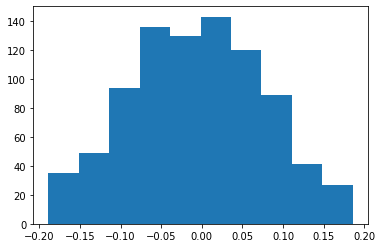

In [29]:
x = layers.Conv2D(32, kernel_size=3, strides=(2, 2), kernel_initializer=CONV_KERNEL_INITIALIZER)
plot_layer_weights(x)